In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-09-11 16:49:06,418	INFO worker.py:1636 -- Started a local Ray instance.


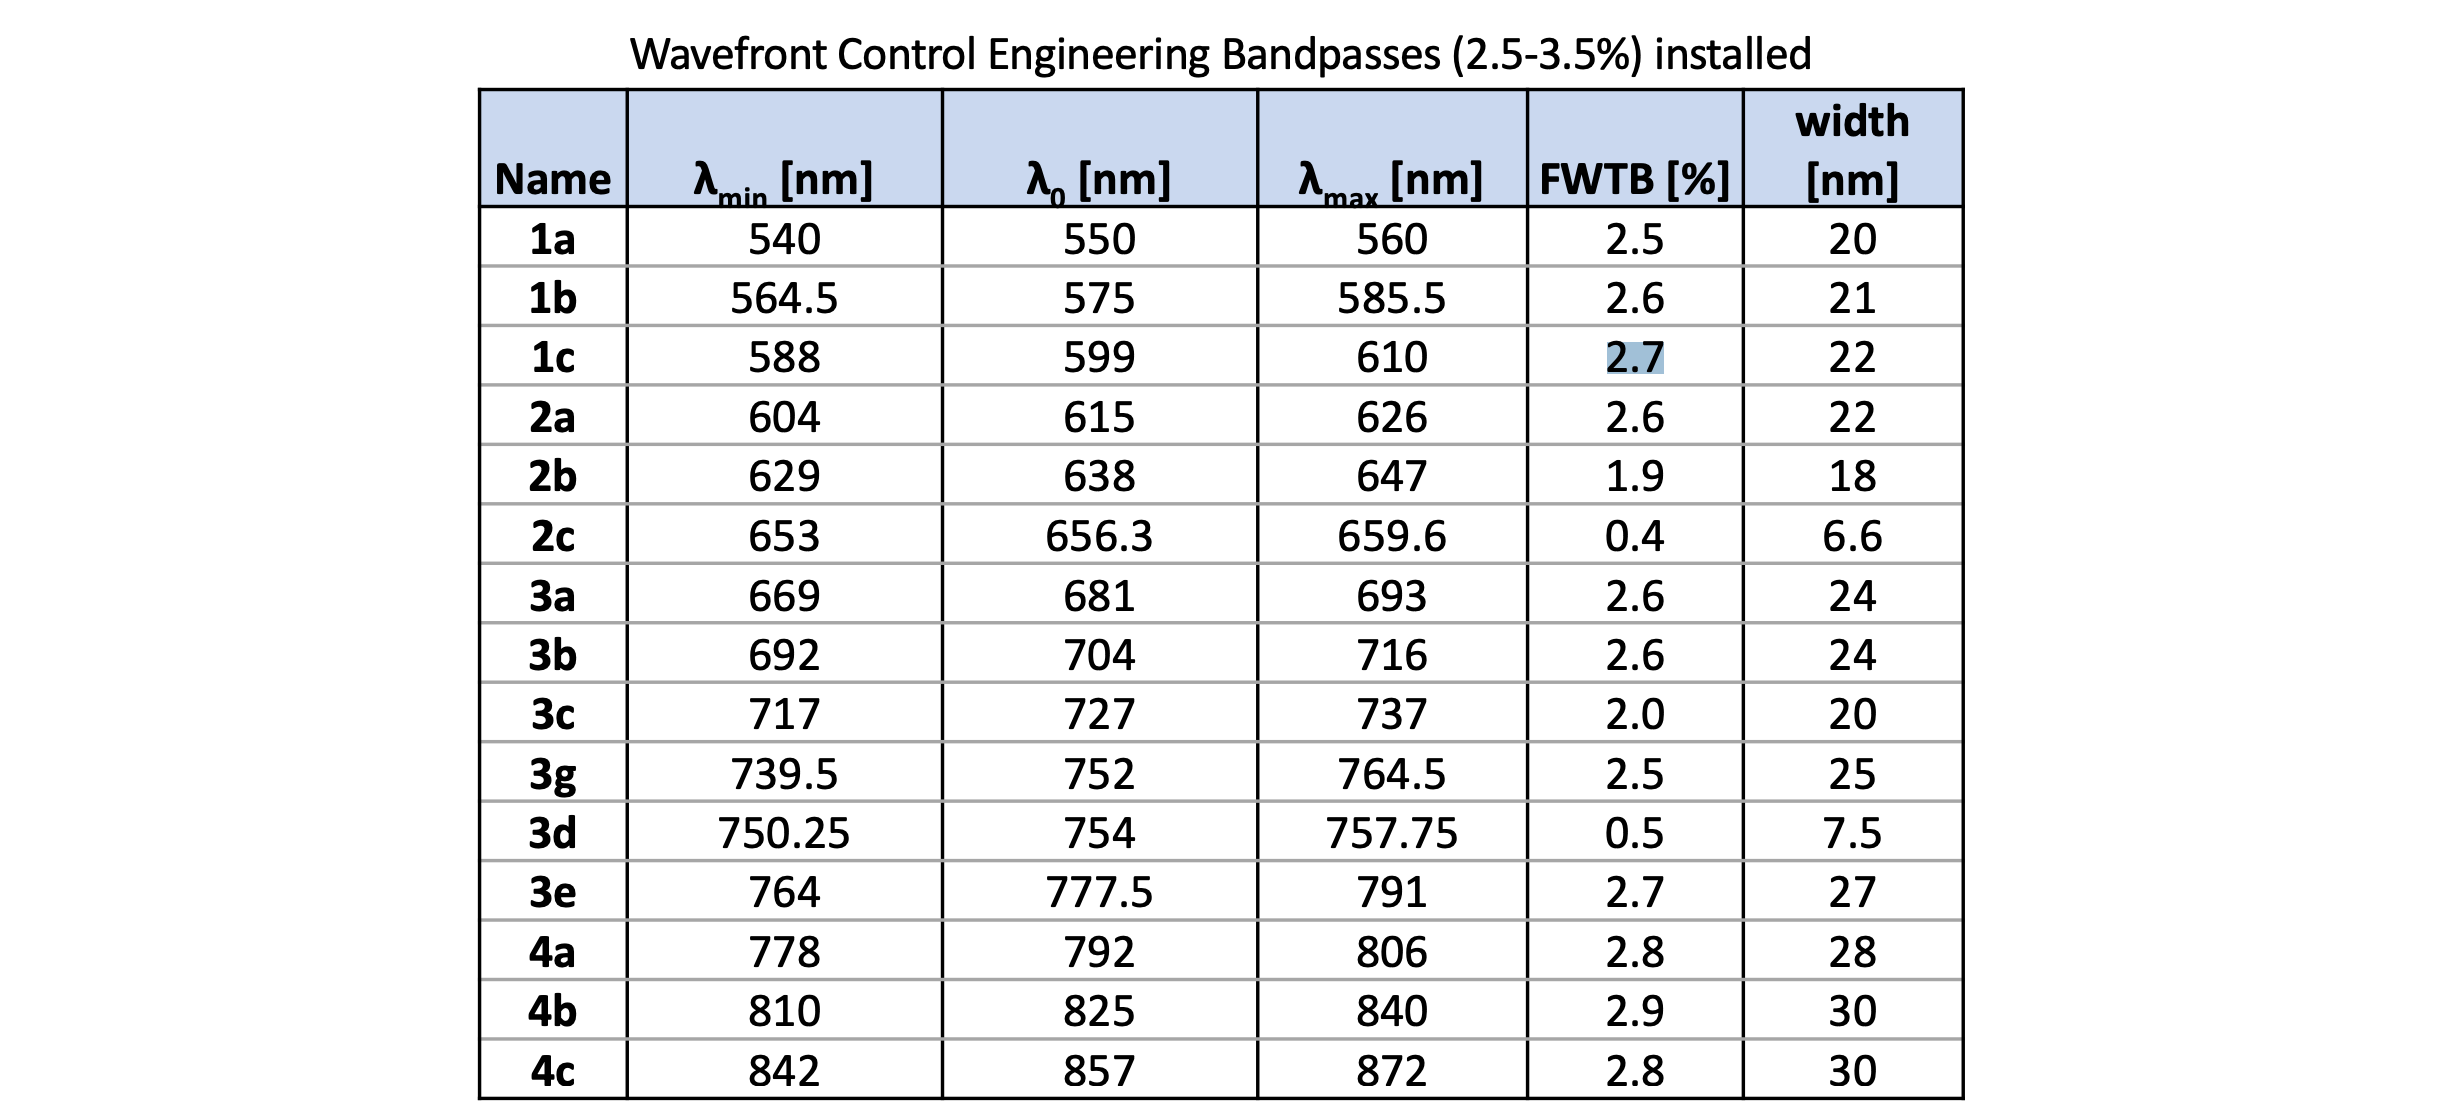

In [23]:
(1000-400)*20 + 1

12001

In [2]:
minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
nlam

12001

1.0521514041110076e-09 rad
3.4778139958039974e-18 sr


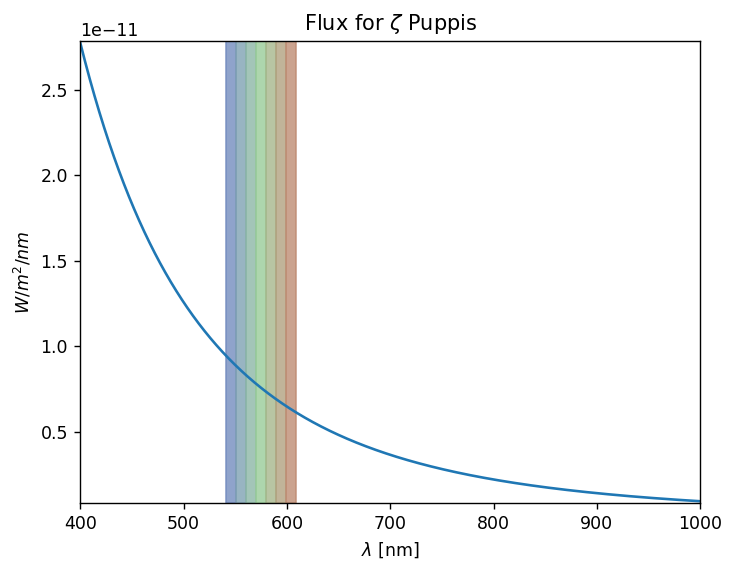

In [3]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 575e-9*u.m

nwaves = 7
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum()
# zpup.plot_spectrum_ph()

source_fluxes = zpup.calc_fluxes()
# print(source_fluxes)
total_flux = np.sum(source_fluxes)
# print(total_flux)

In [4]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide_band1',
    'npsf':100,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [28]:
!nvidia-smi

Thu Sep  7 08:42:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   36C    P0               68W / 300W|  41419MiB / 81920MiB |     10%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

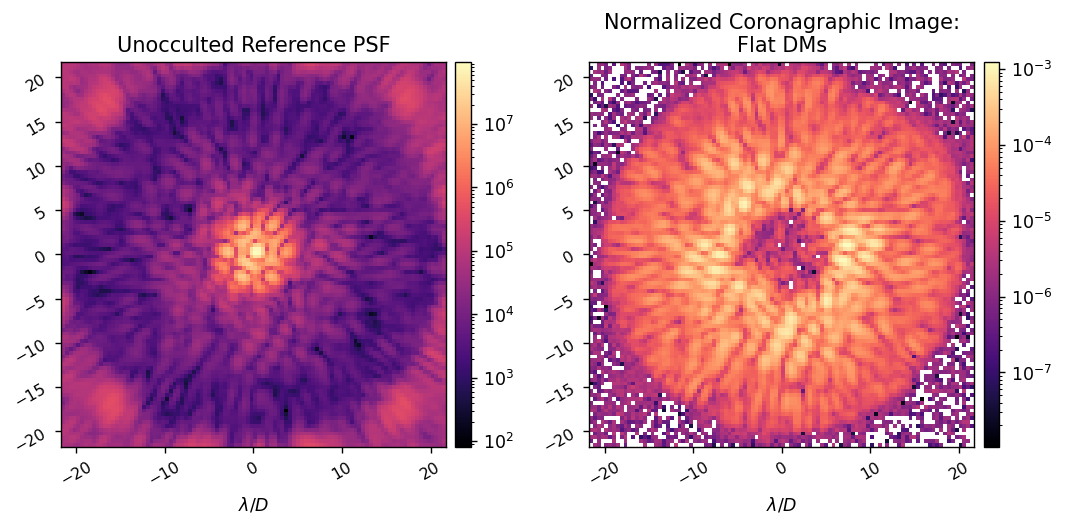

In [12]:
imshow2(ref_unocc_im, ref_im,
        'Unocculted Reference PSF', 'Normalized Coronagraphic Image:\nFlat DMs',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)


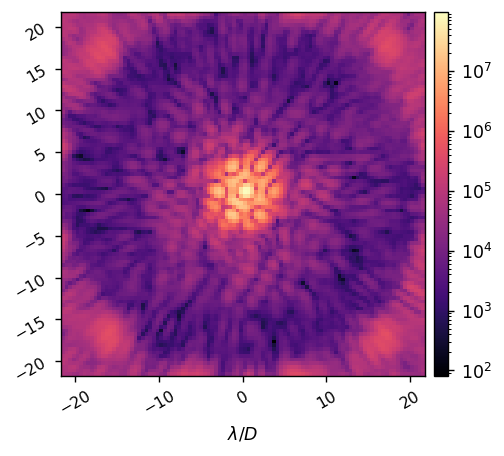

95978501.0


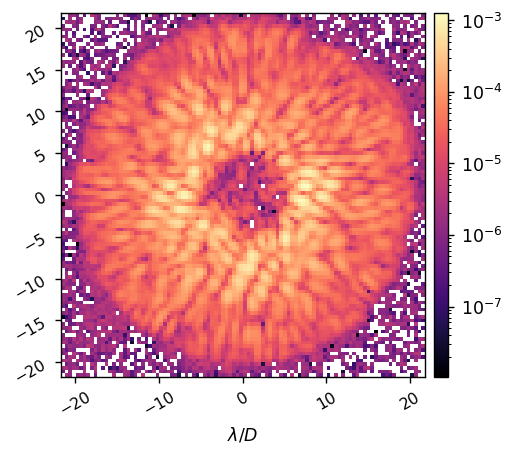

In [9]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 1

ref_im = mode.snap()
imshow1(ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

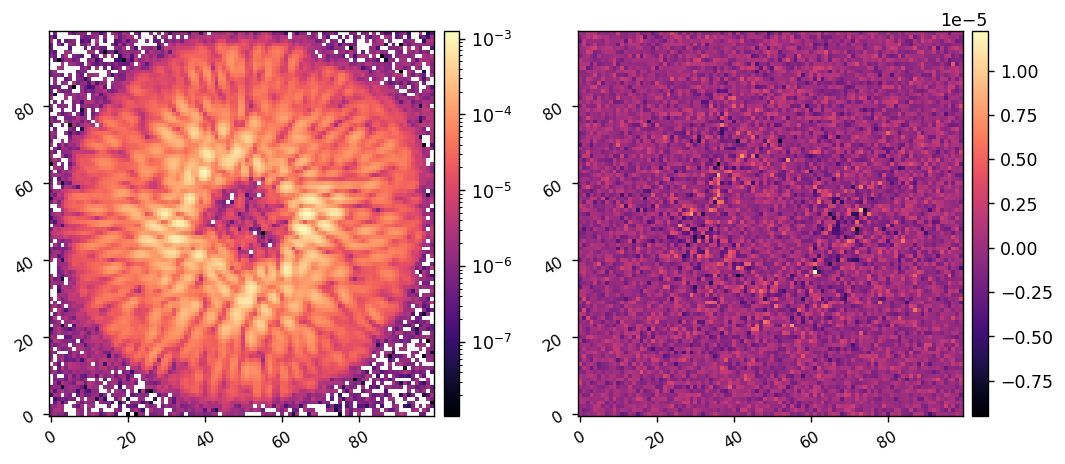

In [6]:
mode.exp_time = 2*u.s
mode.gain = 1
new_im = mode.snap()
imshow2(new_im, ref_im - new_im, lognorm1=True)

# Create dark hole ROI to calibrate and control

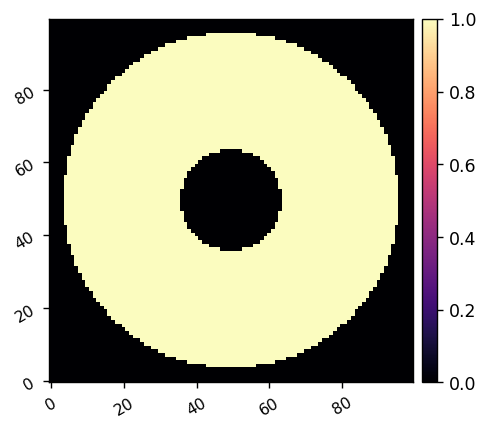

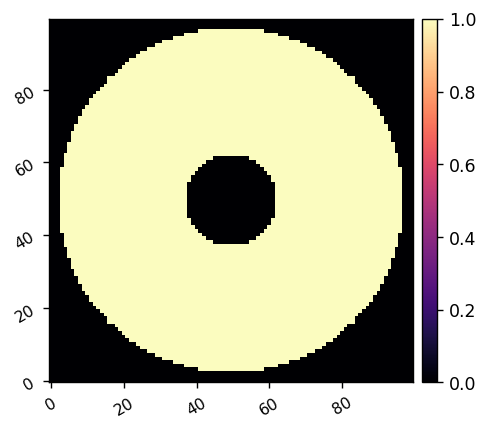

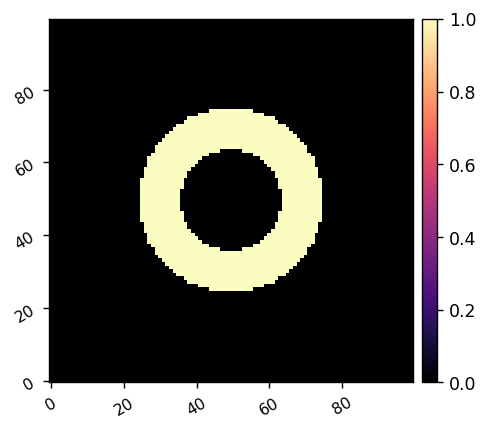

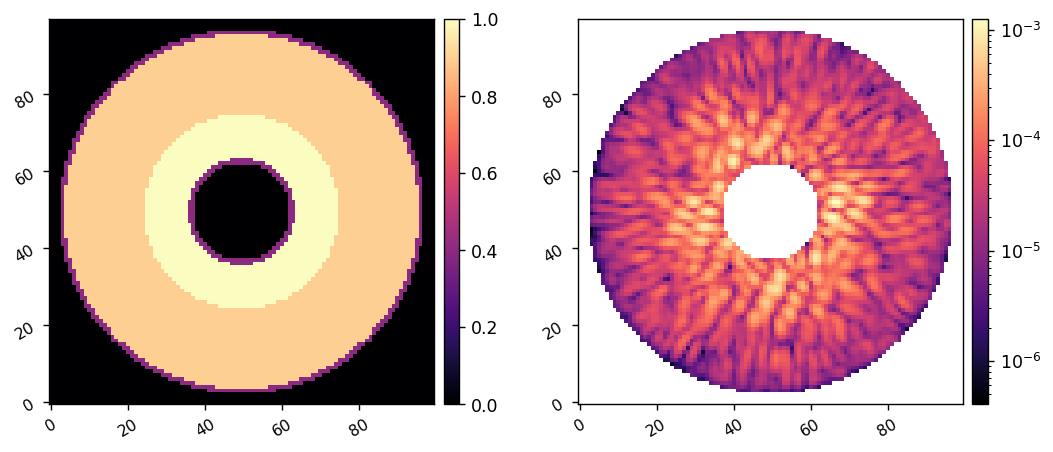

7.609019883071548e-05


In [7]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

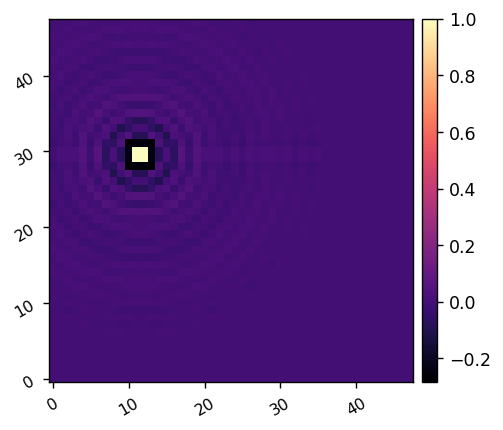

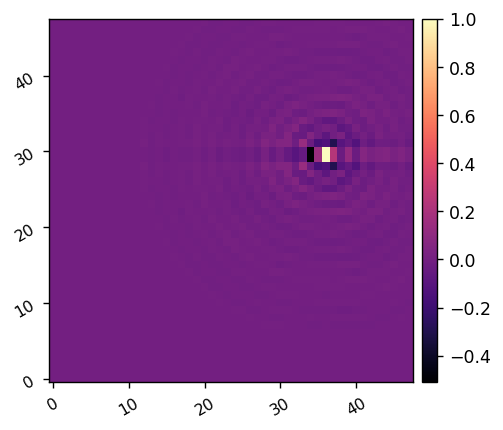

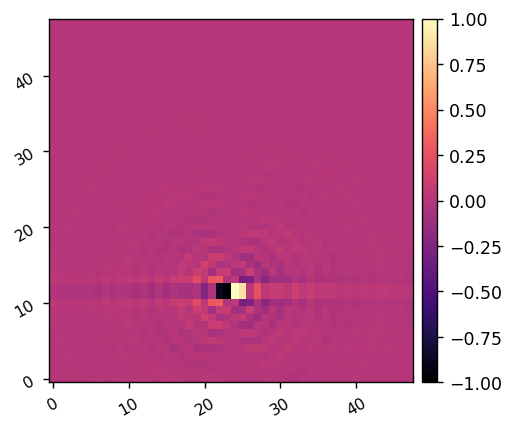

In [8]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2, shift=[(-12,6), (12,6), (0,-12)], nprobes=3, plot=True)


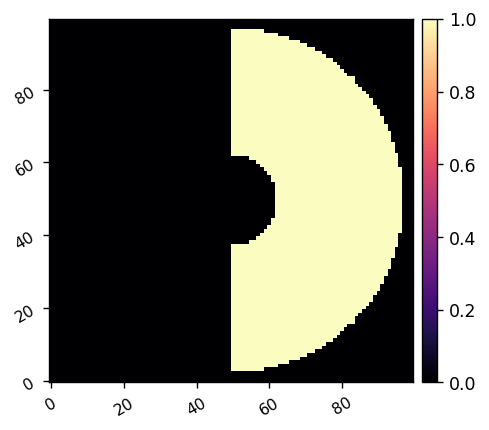

(2568, 4608)


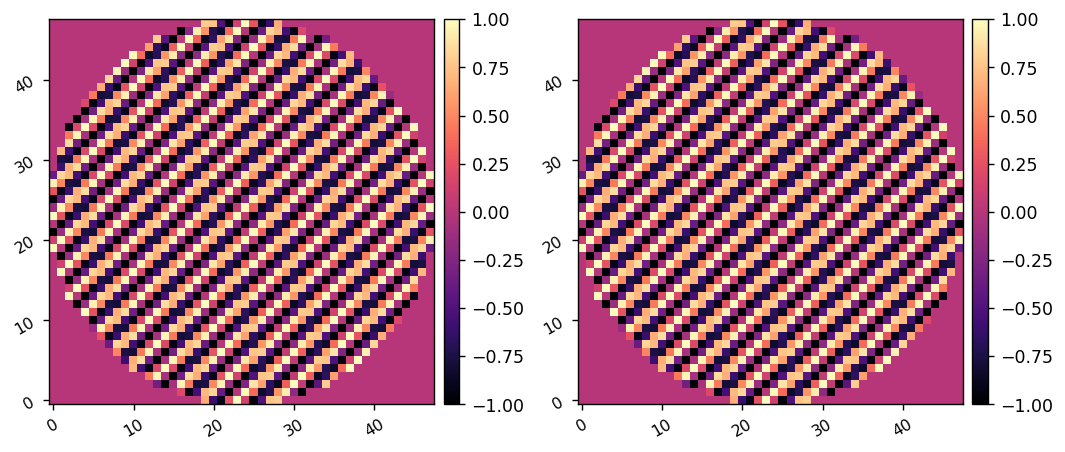

In [10]:
fourier_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=0, plot=True)
fourier_modes = utils.create_fourier_modes(mode, fourier_mask, fourier_sampling=1, ndms=2)
Nfourier = fourier_modes.shape[0]//2
print(fourier_modes.shape)
i = 100
imshow2(fourier_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), fourier_modes[i+Nfourier,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


(4096, 4608)


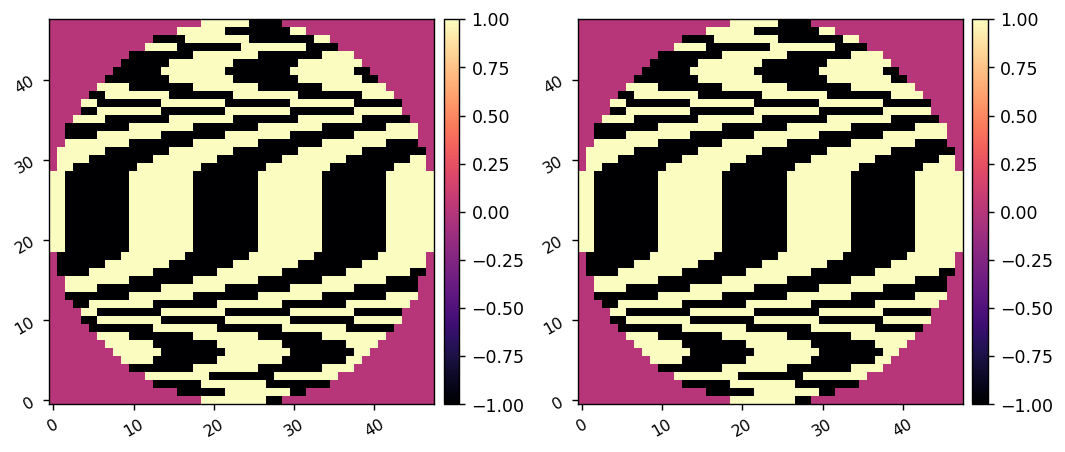

In [11]:
had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nhad = had_modes.shape[0]//2
print(had_modes.shape)
i = 8
imshow2(had_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), had_modes[i+Nhad,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


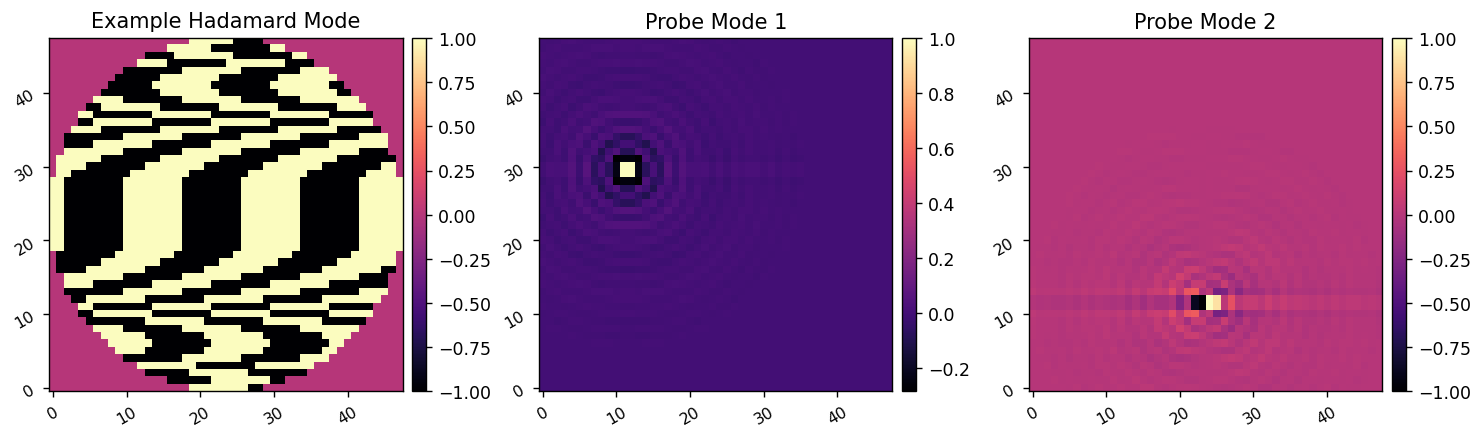

In [15]:
imshow3(had_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), probe_modes[0], probe_modes[2], 
        'Example Hadamard Mode', 'Probe Mode 1', 'Probe Mode 2')

(2048, 2304)
(1276, 2304)
(3324, 2304) (3324, 2304)


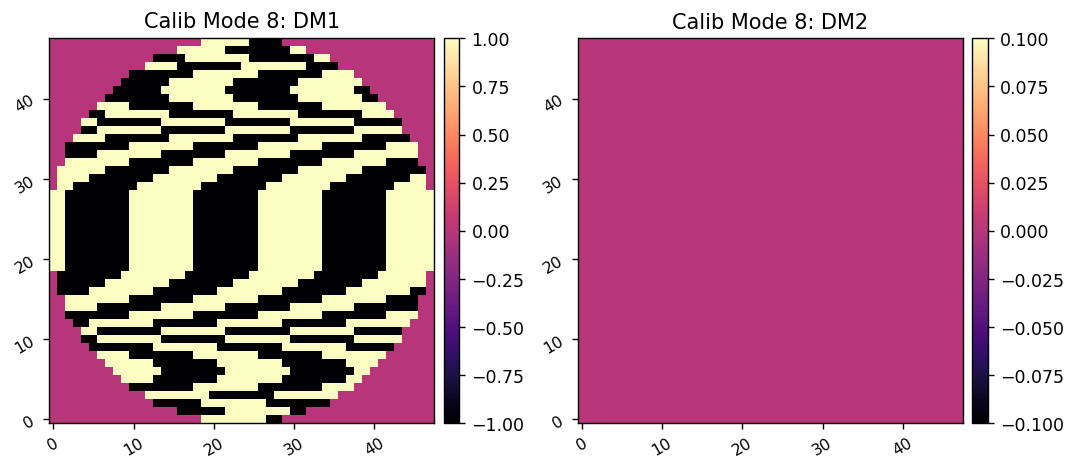

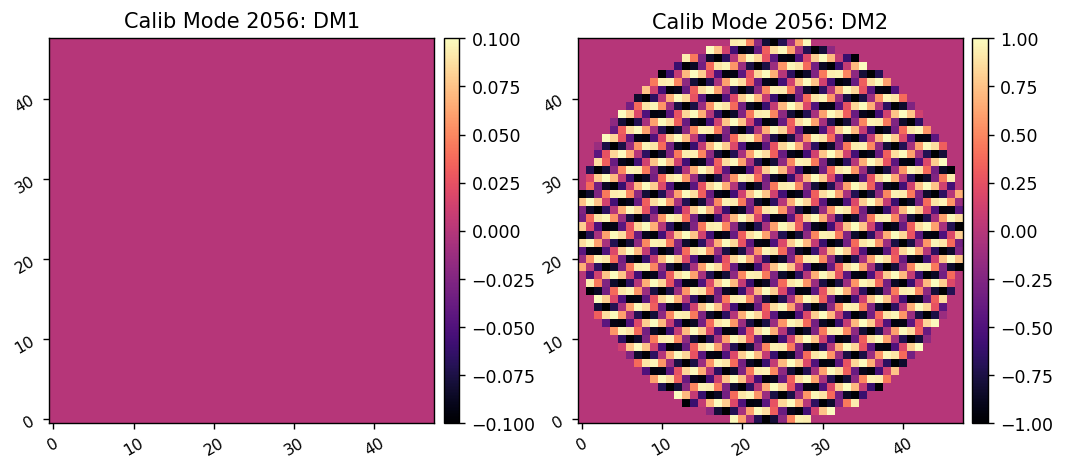

In [41]:
reload(utils)
had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=1)
print(had_modes.shape)

fourier_modes = utils.create_fourier_modes(mode, fourier_mask, fourier_sampling=1, ndms=1)
print(fourier_modes.shape)

Nhad = had_modes.shape[0]
Nf = fourier_modes.shape[0]

calib_modes = utils.create_2dm_mode_matrix(had_modes, fourier_modes)

i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i,mode.Nact**2:].reshape(mode.Nact,mode.Nact),
        f'Calib Mode {i}: DM1', f'Calib Mode {i}: DM2')
imshow2(calib_modes[i+Nhad,:mode.Nact**2:].reshape(mode.Nact,mode.Nact), calib_modes[i+Nhad,mode.Nact**2:].reshape(mode.Nact,mode.Nact),
        f'Calib Mode {i+Nhad}: DM1', f'Calib Mode {i+Nhad}: DM2')

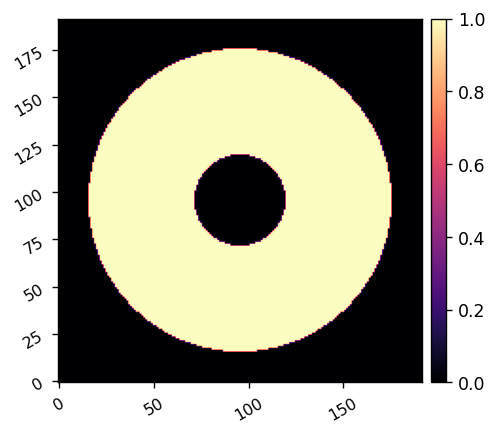

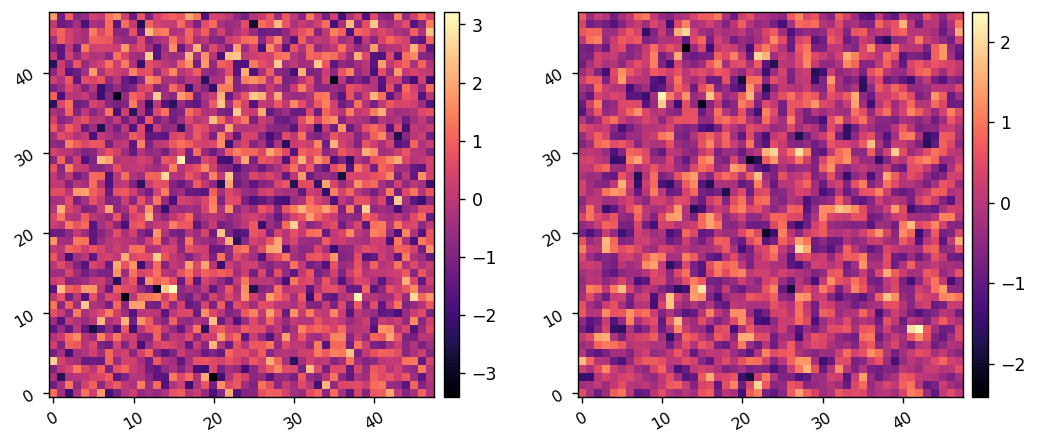

In [60]:
reload(utils)

command = np.random.randn(48,48)
# imshow1(command)

command_filtered = utils.fourier_filter_command(command, 6,20)
imshow2(command, command_filtered.real)

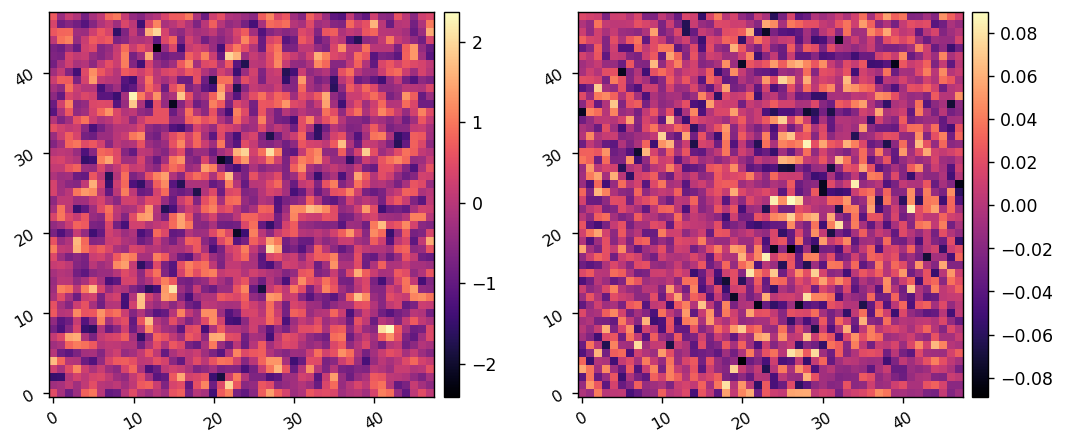

In [61]:
imshow2(command_filtered.real, command_filtered.imag)

In [30]:
2048+1276

3324

In [9]:
calib_amp = 10e-9
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)

print(calib_modes.shape)

# import time
# for i in range(1800,len(calib_modes)):
#     try:
#         imshow2(calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i][mode.Nact**2:].reshape(mode.Nact,mode.Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

(3608, 4608)


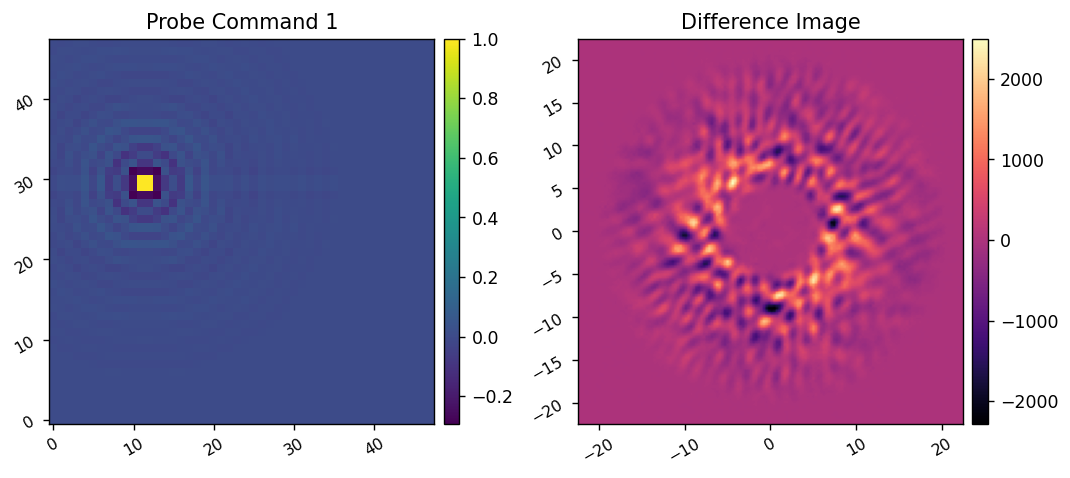

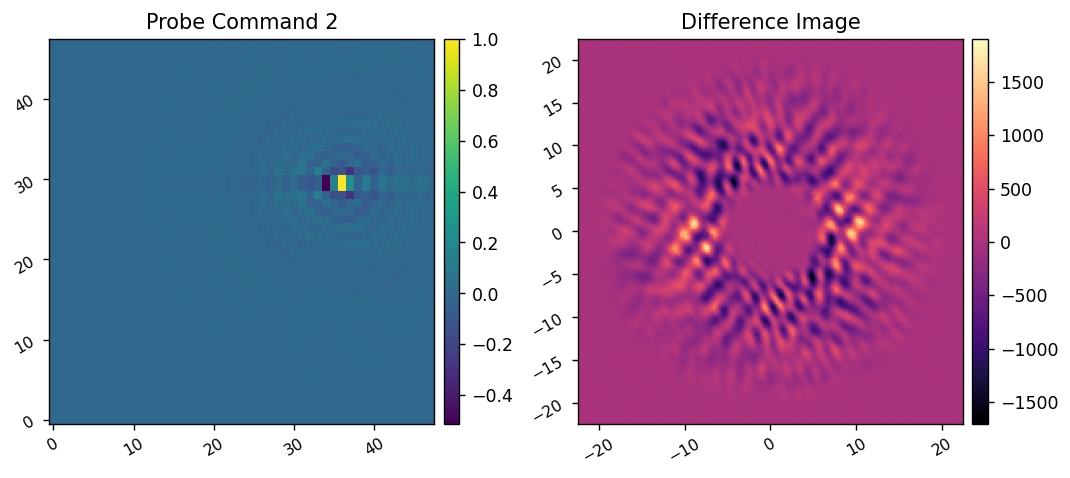

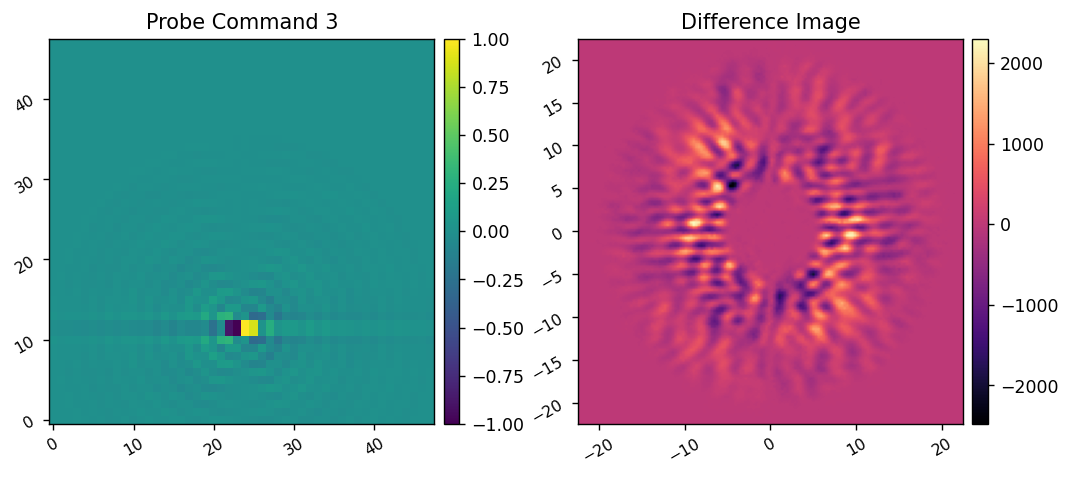

In [35]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)

In [34]:
mode.reset_dms()

In [13]:
reload(iefc_2dm)

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                         calib_amp, calib_modes[:2], 
                                                         return_all=True)


Calibrating iEFC...
	Calibrated mode 2/2 in 23.237s
Calibration complete.


In [12]:
# date = 20230630
# date = 20230703
# date = 20230713
# date = 20230720
# date = 20230723
# date = 20230804
# date = 20230806
# date = 20230808
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_poke_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_poke_response_cube_{date}.fits'))

# date = 20230809
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_had_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_had_response_cube_{date}.fits'))

date = 20230906
response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_wfov_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_wfov_iefc_2dm_poke_response_cube_{date}.fits'))

In [12]:
148**2, 2*control_mask.sum()

(21904, array(27048))

In [25]:
mode.Nacts

1804

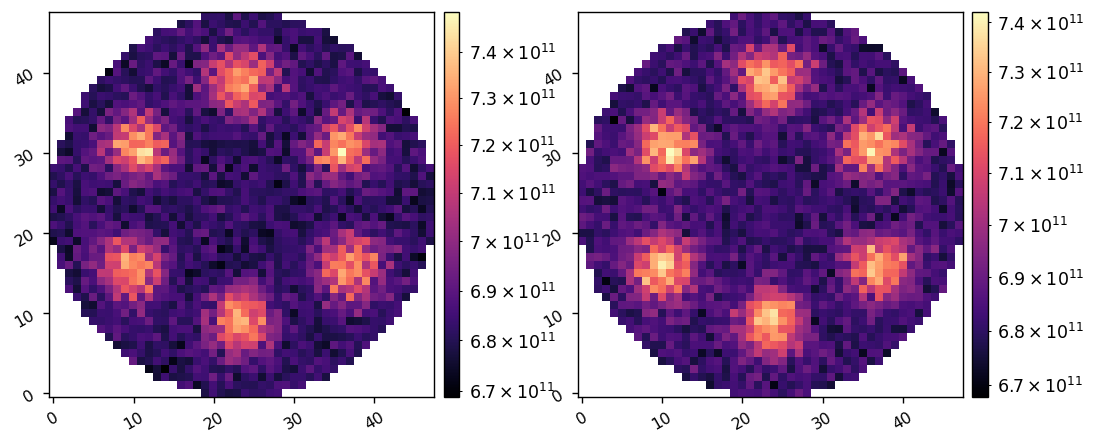

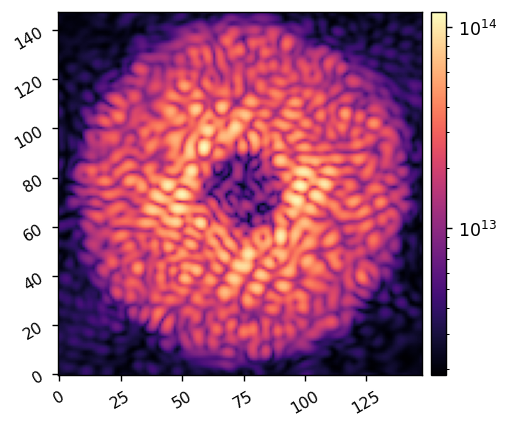

In [13]:
reload(utils)
dm1_response_sum = utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_matrix)**2, axis=0))[:mode.Nacts], mode.dm_mask)
dm2_response_sum = utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_matrix)**2, axis=0))[mode.Nacts:], mode.dm_mask)
imshow2(dm1_response_sum , dm2_response_sum, lognorm=True,)

fp_response_sum = xp.sum(abs(response_cube), axis=(0,1)).reshape(mode.npsf, mode.npsf)
imshow1(fp_response_sum, lognorm=True,)

# Run IEFC

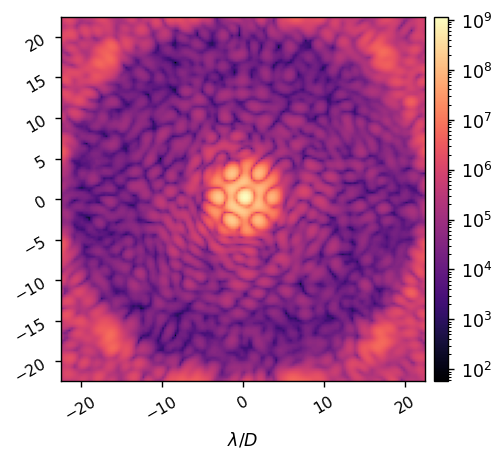

1116141881.0


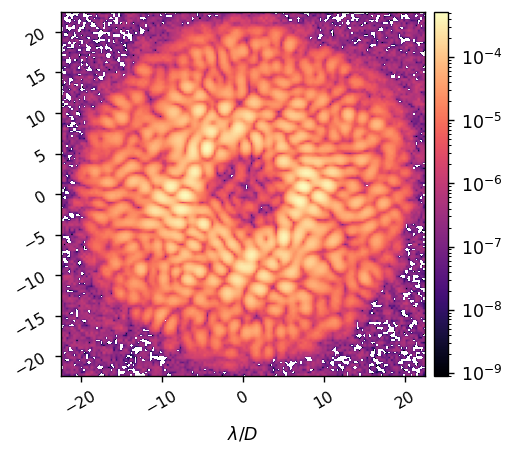

In [20]:
mode.reset_dms()

mode.exp_time = 2*u.s
mode.gain = 100
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

Running iEFC...
	Closed-loop iteration 0 / 5
	Mean NI of this iteration: 2.351e-05


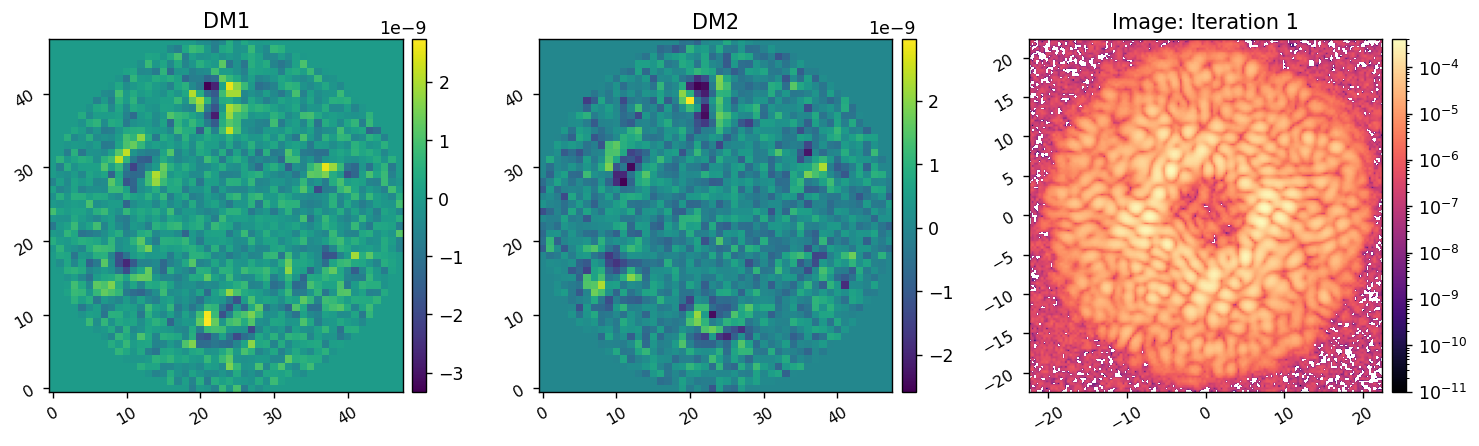

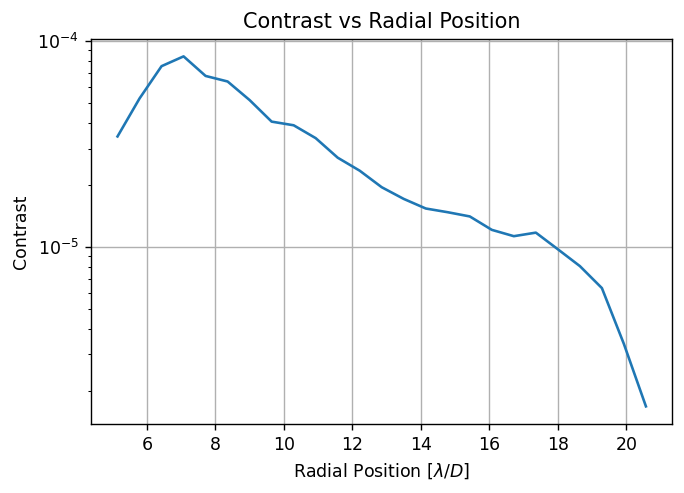

	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 1.870e-05


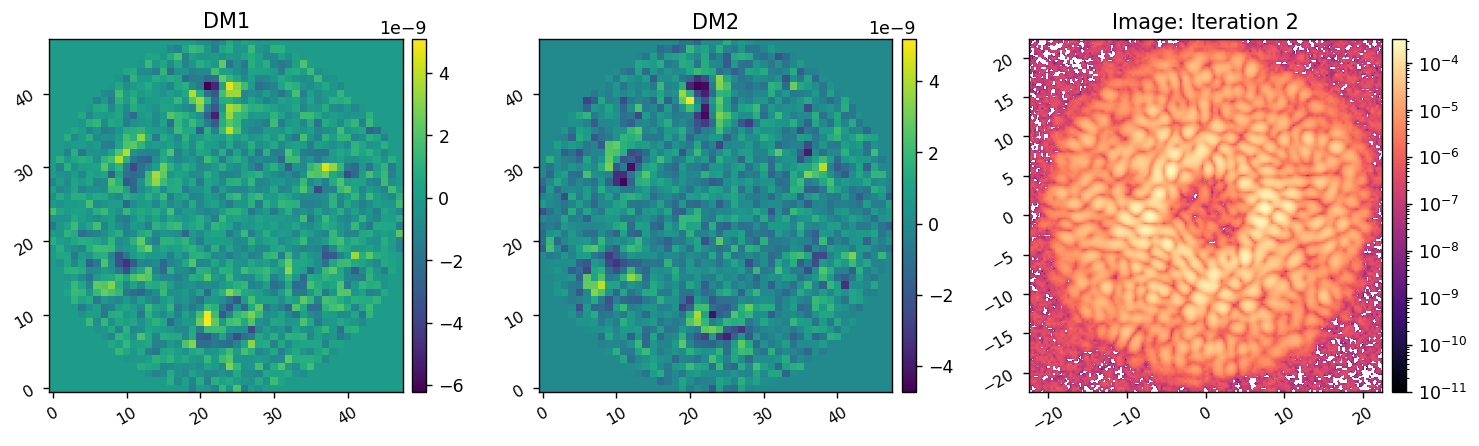

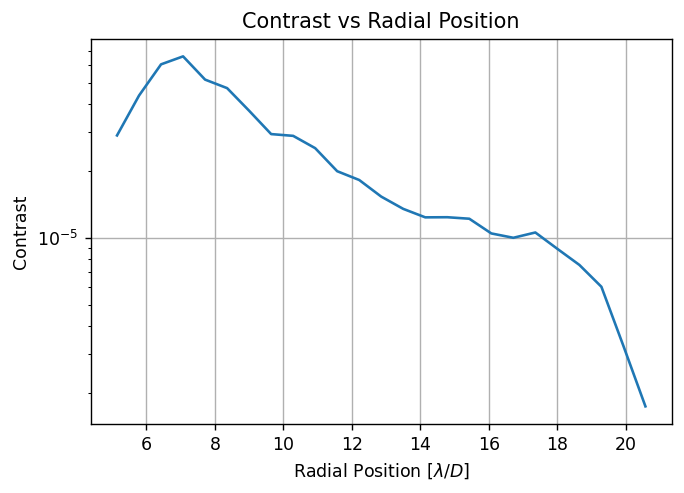

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 1.528e-05


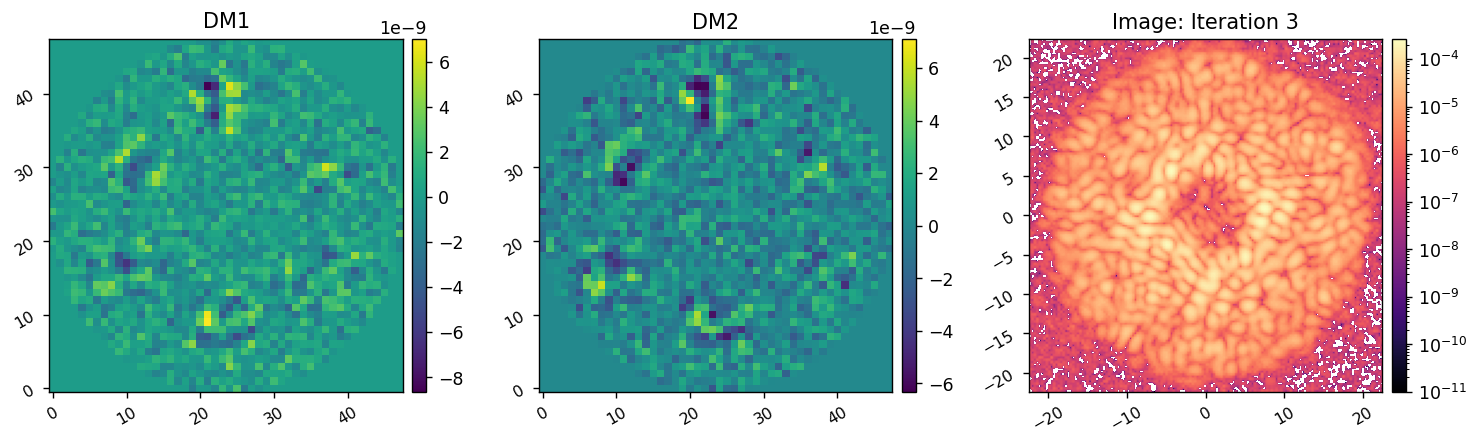

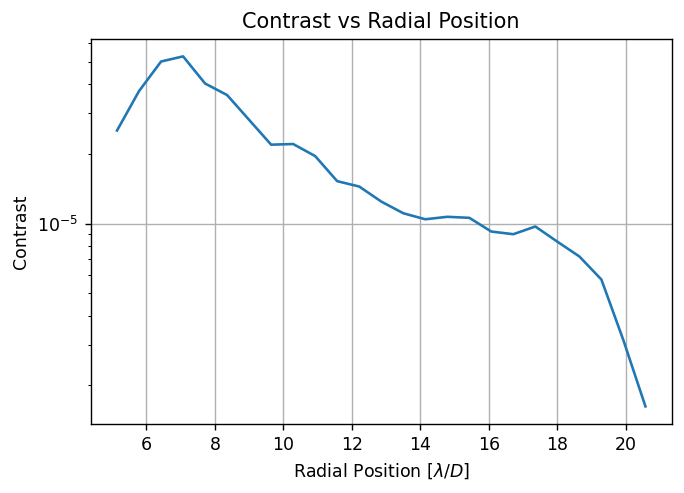

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 1.282e-05


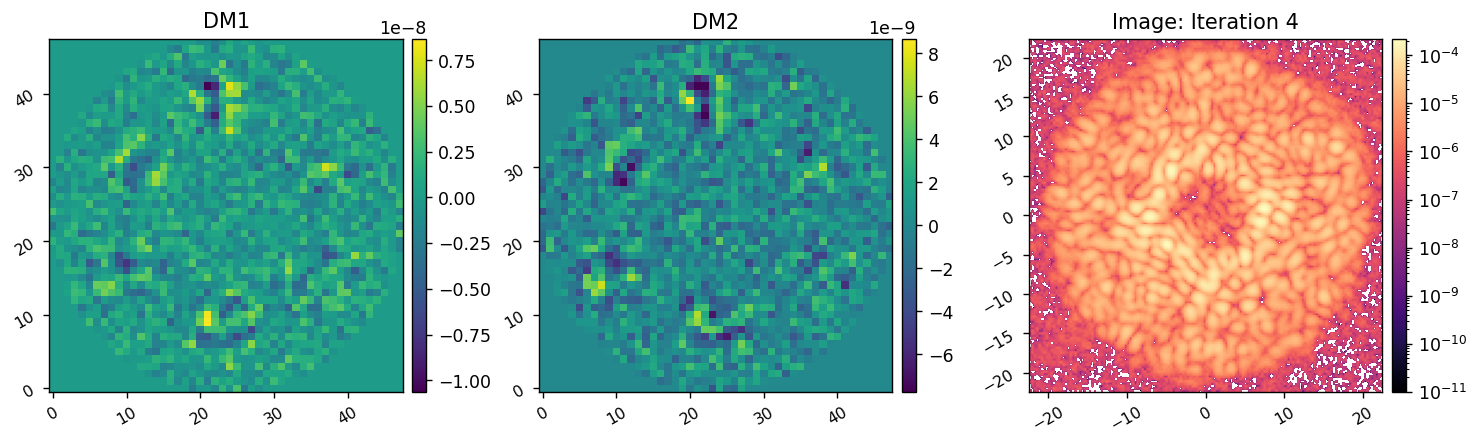

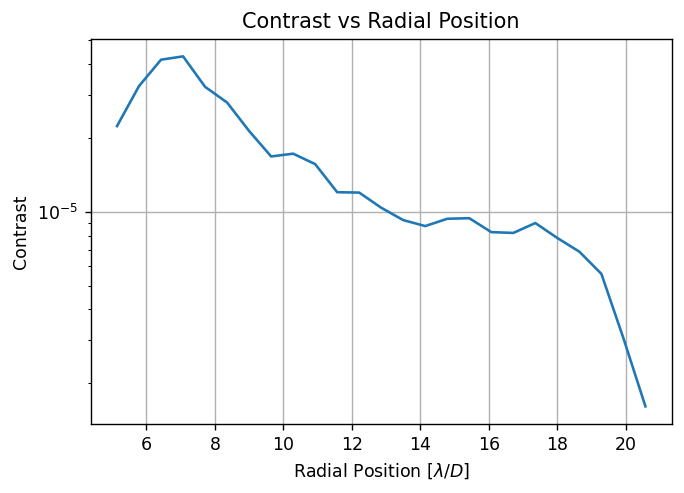

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 1.101e-05


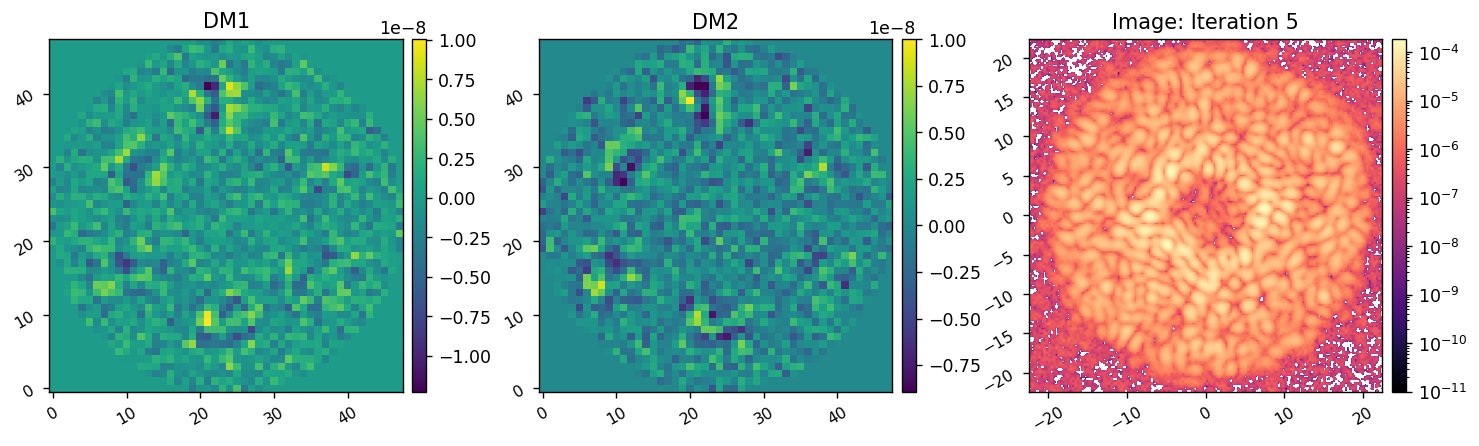

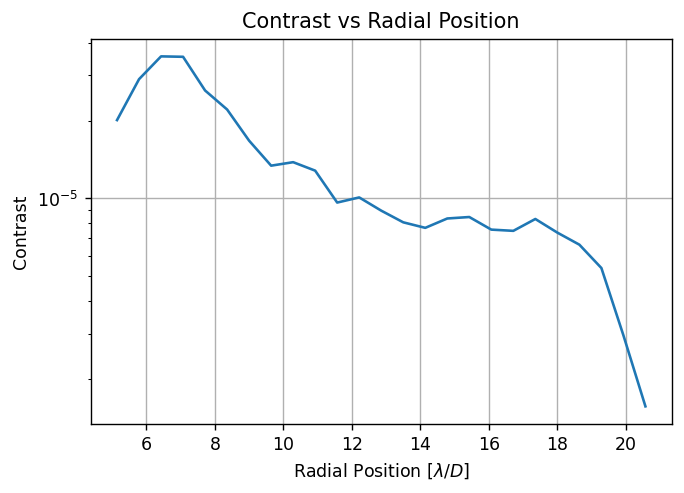

Closed loop for given control matrix completed in 40.209s.


In [21]:
reload(iefc_2dm)
reload(utils)

reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

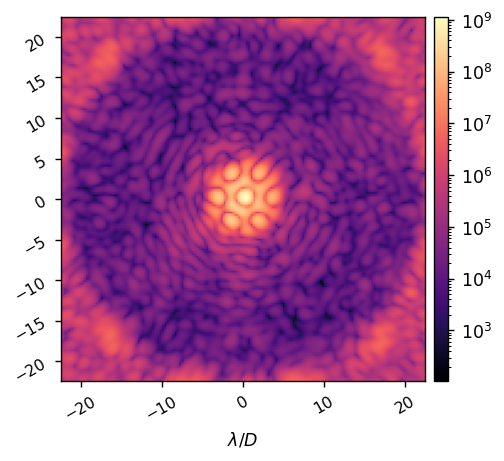

1121663140.8


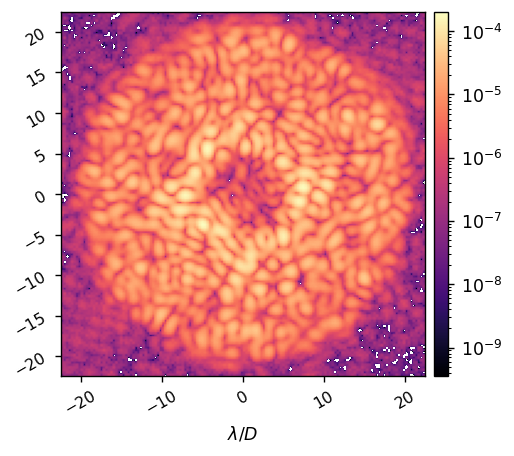

In [22]:
mode.exp_time = 10*u.s
mode.gain = 100
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

Running iEFC...
	Closed-loop iteration 0 / 5
	Mean NI of this iteration: 9.609e-06


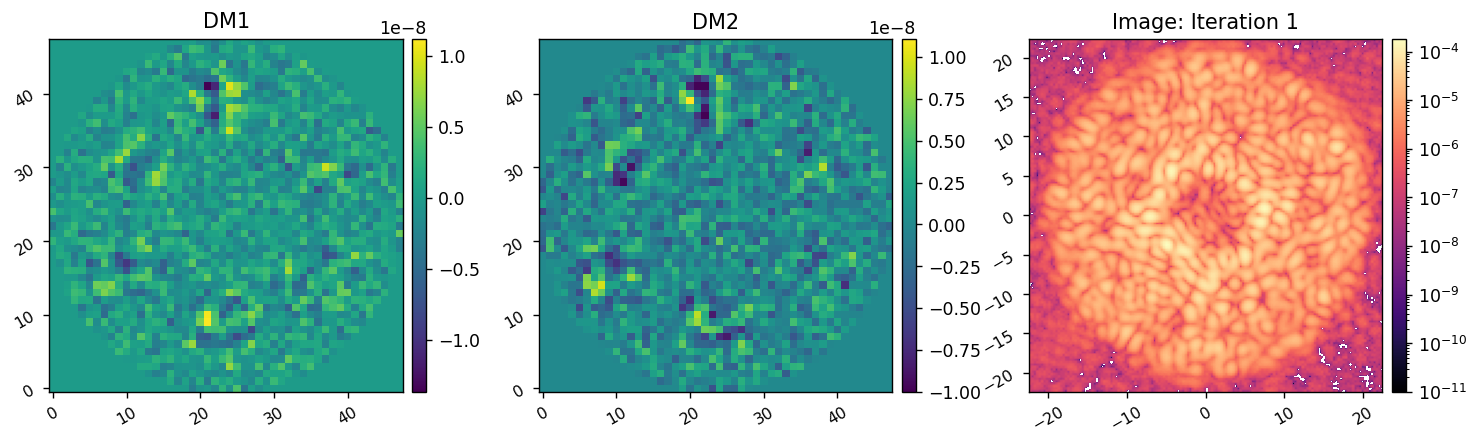

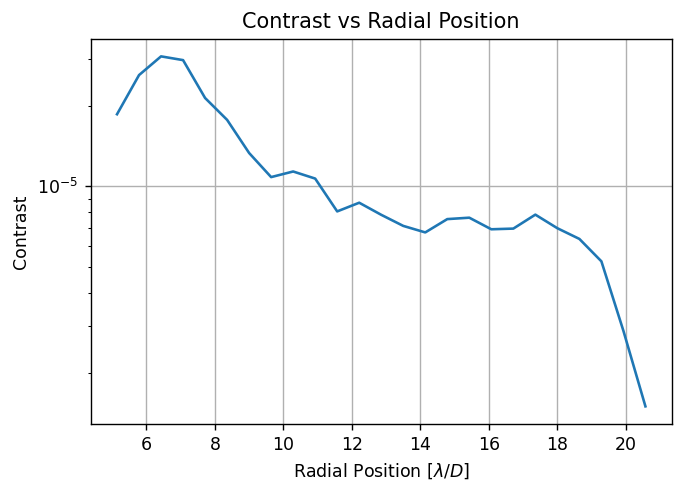

	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 8.577e-06


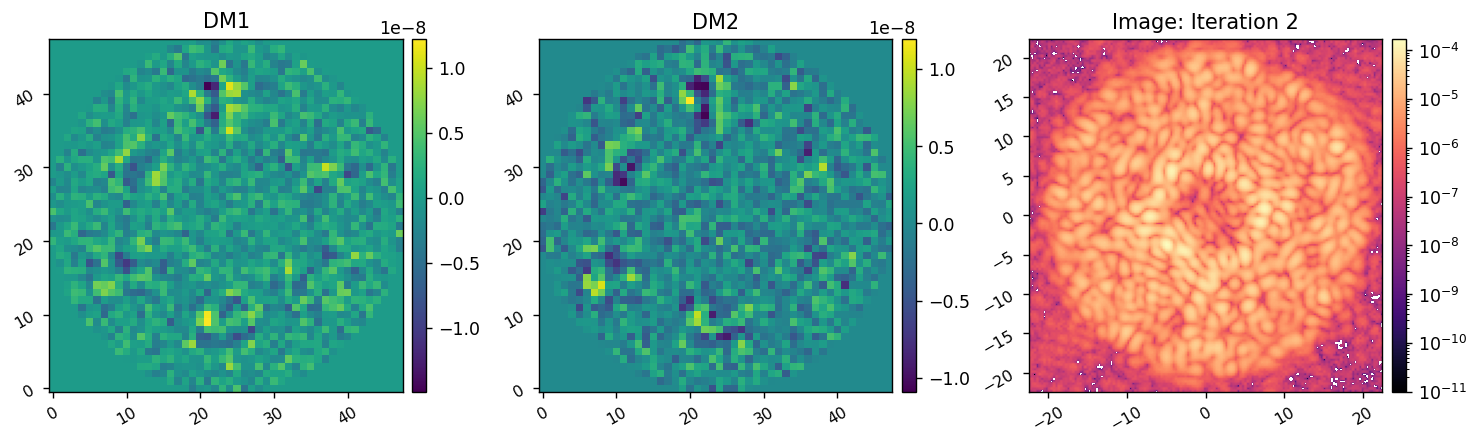

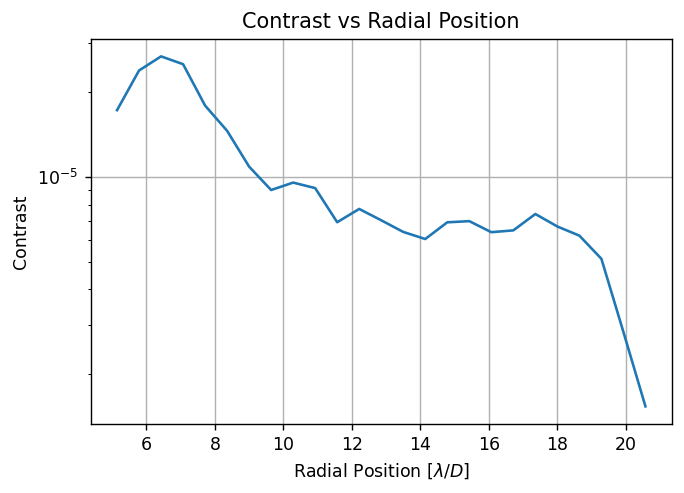

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 7.763e-06


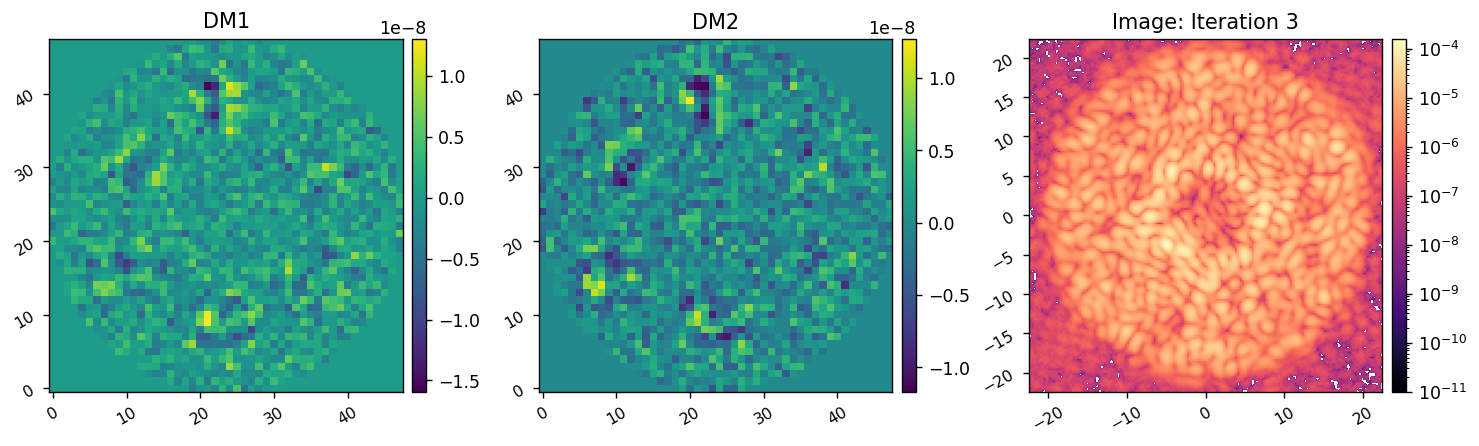

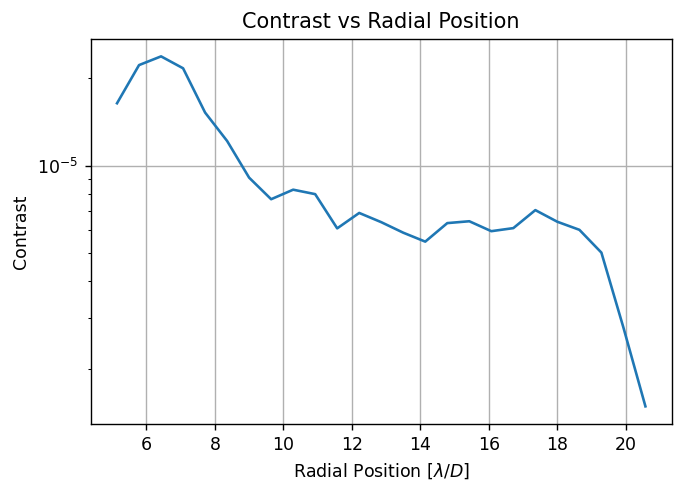

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 7.123e-06


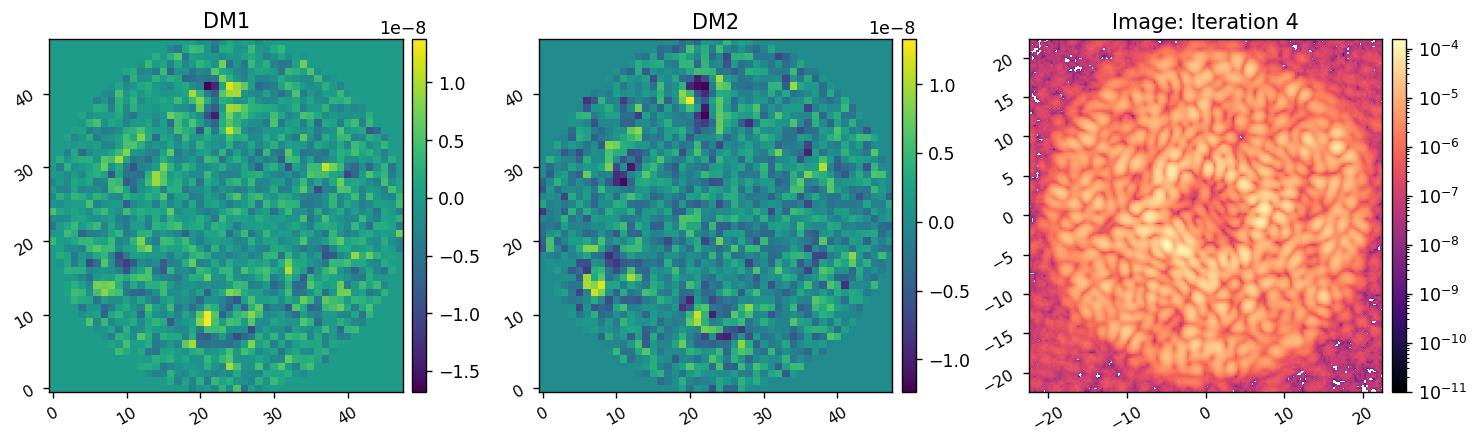

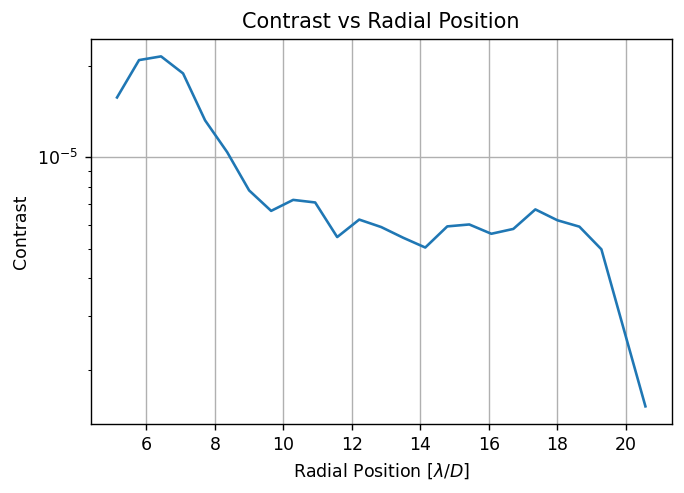

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 6.604e-06


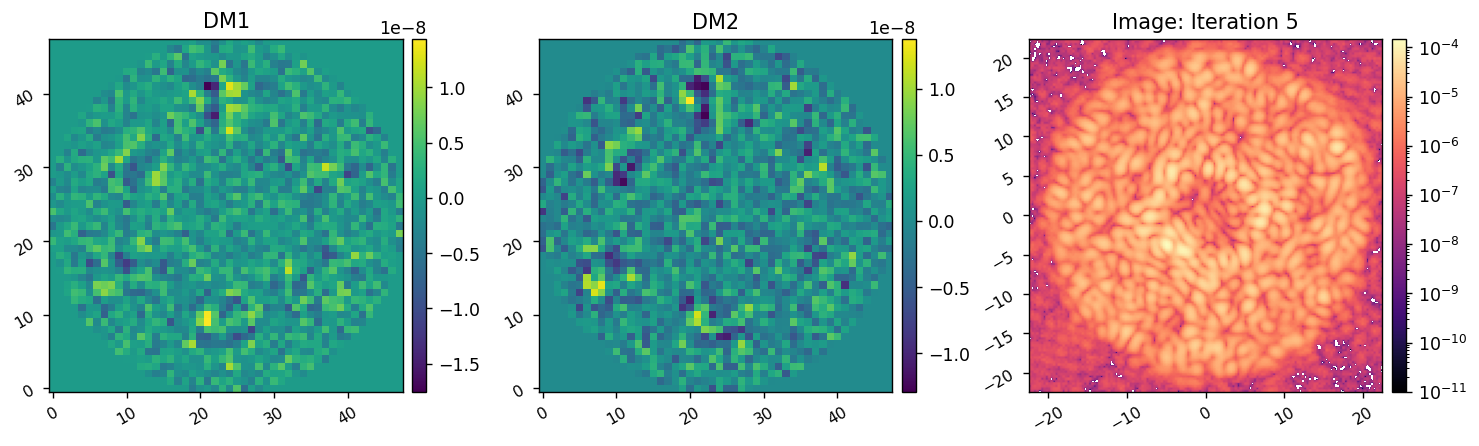

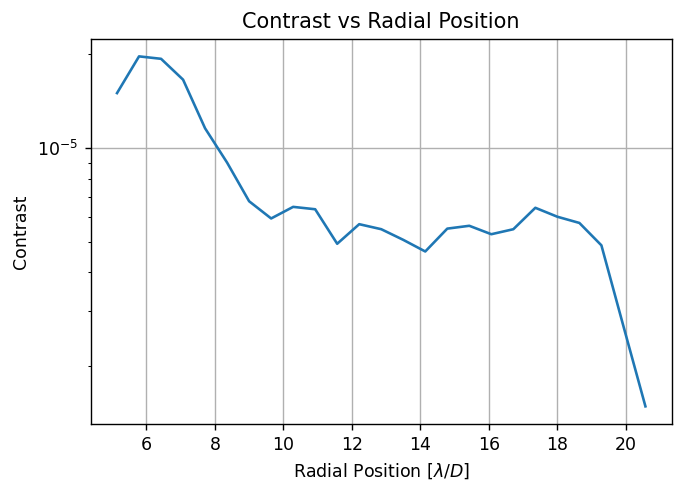

Closed loop for given control matrix completed in 40.261s.


In [23]:
reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=2, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )